NETTOYAGE DE DONNÉES

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import sys
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from xgboost import XGBClassifier
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.optimizers import Adam
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)


In [ ]:
# Use relative path from notebooks/ to data/
file_path = Path("../data/GSE19804_series_matrix.txt")

# Check if file exists
if not file_path.exists():
    print(f"Error: File not found at {file_path}")
    print(f"Please ensure the data file is in the data/ directory")
    sys.exit(1)

# Lire les lignes utiles
try:
    with open(file_path, 'rt') as f:
        lines = f.readlines()
except Exception as e:
    print(f"Error reading file: {e}")
    sys.exit(1)

# Identifier les lignes de début et de fin de la matrice de données
start = None
end = None
for i, line in enumerate(lines):
    if line.startswith("!series_matrix_table_begin"):  # Ligne de début de la matrice
        start = i + 1  # On ignore les lignes de métadonnées
    elif line.startswith("!series_matrix_table_end"):  # Ligne de fin de la matrice
        end = i
        break

if start is None or end is None:
    print("Error: Could not find data matrix markers in file")
    sys.exit(1)

# Lire la matrice de données
df = pd.read_csv(file_path, sep="\t", skiprows=start, nrows=end - start - 1, index_col=0, comment="!")
print(f"✓ Data loaded successfully: {df.shape[0]} genes, {df.shape[1]} samples")
df.head()


,GSM494556,GSM494557,GSM494558,GSM494559,GSM494560,GSM494561,GSM494562,GSM494563,GSM494564,GSM494565,...,GSM494666,GSM494667,GSM494668,GSM494669,GSM494670,GSM494671,GSM494672,GSM494673,GSM494674,GSM494675
ID_REF,,,,,,,,,,,,,,,,,,,,,
1007_s_at,11.96280,11.38780,11.19280,11.90360,11.75230,11.04240,10.74160,11.71090,11.46260,11.49050,...,10.35930,10.55280,10.81930,10.97170,10.38300,10.60120,11.19790,10.84320,10.60670,9.37942
1053_at,7.05652,7.33711,7.26121,7.91211,8.27448,7.60698,9.80415,8.85862,7.80342,8.43741,...,7.69447,7.80456,7.87718,7.64986,7.80042,7.92790,7.85849,7.91834,8.05853,7.51433
117_at,6.55585,6.96023,7.14488,7.13887,7.72479,8.01441,8.88544,7.99740,7.33263,10.54530,...,7.44120,7.82203,8.46291,7.68880,9.54127,8.62987,7.88748,7.85222,7.24397,8.83099
121_at,8.43850,8.51636,8.43138,8.67404,8.78145,8.55224,8.86868,8.15469,8.72485,8.13286,...,8.33440,8.18781,8.46548,8.23930,8.60798,8.59521,8.66340,8.33596,8.66742,8.46711
1255_g_at,3.73169,3.77978,3.99853,3.69171,3.93509,3.54508,4.14981,6.99991,4.38131,4.05949,...,3.73375,3.59215,3.74585,3.73324,3.65606,3.71172,3.84361,3.75038,3.87179,3.71853


In [35]:
print(f"Shape: {df.shape}") # Afficher la forme du DataFrame
print(f"Samples: {df.columns[:5]}") # Afficher les 5 premières colonnes 
df = df.loc[:, df.columns.notna()]  # Supprimer les colonnes avec des noms manquants    
df = df[~df.index.duplicated(keep='first')] # Supprimer les lignes dupliquées
df = df.apply(pd.to_numeric, errors='coerce')  # Convertir les valeurs en numériques, en remplaçant les erreurs par NaN    
print("Valeurs manquantes :", df.isnull().sum().sum())  # Afficher le nombre de valeurs manquantes

Shape: (54675, 120)
Samples: Index(['GSM494556', 'GSM494557', 'GSM494558', 'GSM494559', 'GSM494560'], dtype='object')
Valeurs manquantes : 0


In [36]:
df.dropna(inplace=True) # Remove rows with any NaN values
df.fillna(df.mean(), inplace=True) # Fill NaN values with the mean of each column
df = df.loc[:, (df != 0).any(axis=0)]  # Remove columns with all zeros
df_T = df.T  # Transposer pour que chaque ligne soit un échantillon
scaler = StandardScaler() # Standarize features by removing the mean and scaling to unit variance
df_scaled = pd.DataFrame(scaler.fit_transform(df_T), index=df_T.index, columns=df_T.columns) # Standardisation des données (Z-score) pour chaque gène
# Vérifier que df_scaled est bien prêt :
print("Scaled_df shape:", df_scaled.shape)
print("Valeurs manquantes:", df_scaled.isnull().sum().sum())  # Afficher la somme des valeurs manquantes après la standardisation



Scaled_df shape: (120, 54675)
Valeurs manquantes: 0


In [37]:
# Réduction à 2 dimensions pour la visualisation uniquement
pca = PCA(n_components=2) 
X_pca = pca.fit_transform(df_scaled) # Projection des données dans l'espace PCA
# Afficher la variance expliquée par chaque composante principale
print(f"Variance expliquée par chaque composante principale : {pca.explained_variance_ratio_}")
# Stocker la projection dans un DataFrame
df_pca = pd.DataFrame(X_pca, columns=['PC1', 'PC2'])


Variance expliquée par chaque composante principale : [0.16069627 0.11055432]


DÉTECTION D’ANOMALIES PAR IsolationForest

In [38]:
# Initialiser le modèle Isolation Forest
iso_forest = IsolationForest(n_estimators=100, contamination = 0.1, random_state=42)

# Entraînement du modèle sur les données standardisées
iso_forest.fit(df_scaled)

# Prédiction des anomalies : -1 = anomalie, 1 = normal
df_pca['Anomaly_IF'] = iso_forest.predict(df_scaled)


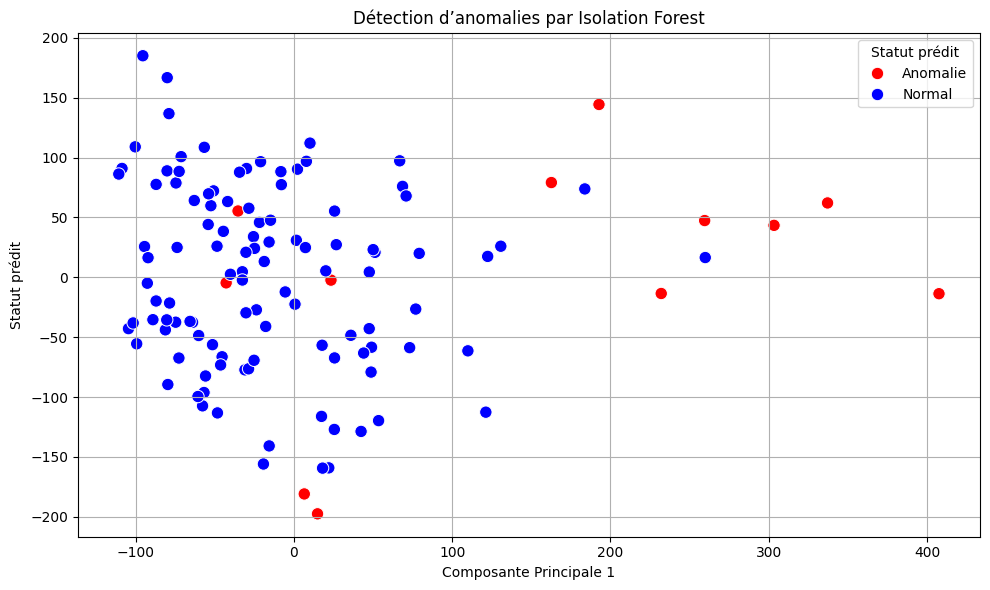

In [39]:
# Créer une nouvelle colonne texte pour affichage
df_pca['Anomaly_Label'] = df_pca['Anomaly_IF'].map({1: "Normal", -1: "Anomalie"})

# Utiliser cette colonne pour la couleur
plt.figure(figsize=(10, 6))
sns.scatterplot(
    data=df_pca, # DataFrame avec les composantes principales et les étiquettes d'anomalies
    x='PC1', y='PC2',  # Composantes principales pour les axes
    hue='Anomaly_Label',  # Couleur basée sur l'étiquette d'anomalie
    palette={"Normal": "blue", "Anomalie": "red"},  # Palette de couleurs pour les étiquettes
    s=80 # Taille des points
)

plt.title("Détection d’anomalies par Isolation Forest")
plt.xlabel("Composante Principale 1")
plt.ylabel("Statut prédit")
plt.legend(title="Statut prédit")
plt.grid(True)
plt.tight_layout()
plt.show()


DÉTECTION D’ANOMALIES PAR AUTOENCODEUR

In [40]:
# Taille d'entrée = nombre de gènes
n_features = df_scaled.shape[1]
# Architecture de l'autoencodeur
input_layer = Input(shape=(n_features,)) # Entrée de l'autoencodeur avec le nombre de gènes comme dimension
encoded = Dense(64, activation='relu')(input_layer) # Couche cachée avec 64 neurones et activation ReLU
encoded = Dense(32, activation='relu')(encoded) # Couche cachée avec 32 neurones et activation ReLU
decoded = Dense(64, activation='relu')(encoded) # Couche cachée avec 64 neurones et activation ReLU
output_layer = Dense(n_features, activation='linear')(decoded) # Couche de sortie avec le même nombre de neurones que l'entrée et activation linéaire

# Modèle de l'autoencodeur  
autoencoder = Model(inputs=input_layer, outputs=output_layer) # Création du modèle de l'autoencodeur avec les couches définies
autoencoder.compile(optimizer=Adam(learning_rate=0.001), loss='mse') # Compilation du modèle avec l'optimiseur Adam et la fonction de perte MSE (erreur quadratique moyenne)

# Entraînement sur données normales
history = autoencoder.fit(
    df_scaled, df_scaled, # Entraînement de l'autoencodeur sur les données standardisées
    epochs=50, # Nombre d'époques pour l'entraînement
    batch_size=16, # Taille du lot pour l'entraînement
    shuffle=True, # Mélanger les données à chaque époque
    validation_split=0.1, # Fraction des données à utiliser pour la validation
    verbose=0 # Afficher les informations d'entraînement (0 pour silencieux, 1 pour afficher la progression, 2 pour afficher uniquement les erreurs)
)


In [41]:
# Reconstruction
reconstructed = autoencoder.predict(df_scaled)
# Erreur quadratique moyenne par échantillon
reconstruction_error = np.mean(np.square(df_scaled - reconstructed), axis=1)
# Ajouter au DataFrame PCA 
df_pca['Reconstruction_Error'] = reconstruction_error


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


In [42]:
# Reconstruction du df_pca avec index aligné
df_pca = pd.DataFrame(X_pca, columns=["PC1", "PC2"], index=df_scaled.index)

# Ajouter l’erreur de reconstruction
df_pca['Reconstruction_Error'] = reconstruction_error

# Ajouter les prédictions Isolation Forest
df_pca['Anomaly_IF'] = iso_forest.predict(df_scaled).astype(int)

# Détection AE : seuil basé sur le 90e percentile
threshold = np.percentile(reconstruction_error, 90)

# Détection des anomalies : -1 = anomalie, 1 = normal
df_pca['Anomaly_AE'] = (df_pca['Reconstruction_Error'] > threshold).astype(int)
df_pca['Anomaly_AE'] = df_pca['Anomaly_AE'].map({0: 1, 1: -1})  # alignement avec Isolation Forest

# Ajouter un label lisible
df_pca['AE_Label'] = df_pca['Anomaly_AE'].map({1: "Normal", -1: "Anomalie"})


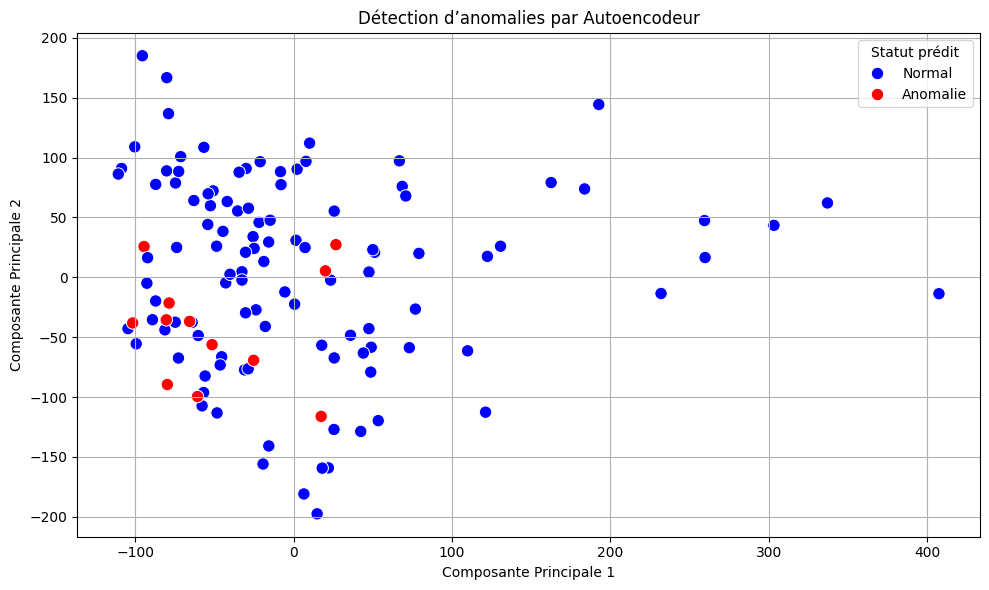

In [43]:
plt.figure(figsize=(10, 6))
sns.scatterplot(
    data=df_pca,
    x='PC1', y='PC2',
    hue='AE_Label',
    palette={"Normal": "blue", "Anomalie": "red"},
    s=80
)

plt.title("Détection d’anomalies par Autoencodeur")
plt.xlabel("Composante Principale 1")
plt.ylabel("Composante Principale 2")
plt.legend(title="Statut prédit")
plt.grid(True)
plt.tight_layout()
plt.show()


DÉTECTION D’ANOMALIES PAR LOCAL OUTLIER FACTOR (LOF)

In [44]:
# Initialiser le modèle
lof = LocalOutlierFactor(
    n_neighbors=20,      # nombre de voisins (par défaut)
    contamination=0.1,   # proportion d’anomalies estimée
    novelty=False        # mode "fit_predict" uniquement
)
# Prédiction directe (pas d'entraînement séparé avec LOF)
lof_preds = lof.fit_predict(df_scaled)  # -1 = anomalie, 1 = normal
# Ajout au DataFrame PCA
df_pca['Anomaly_LOF'] = lof_preds 
df_pca['LOF_Label'] = df_pca['Anomaly_LOF'].map({1: "Normal", -1: "Anomalie"})


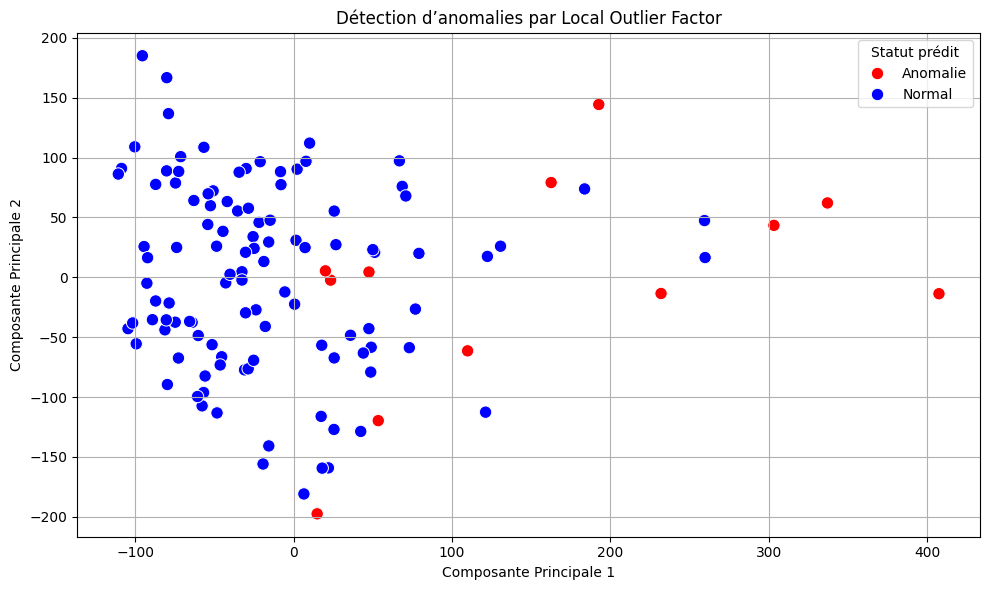

In [45]:
plt.figure(figsize=(10, 6))
sns.scatterplot(
    data=df_pca,
    x='PC1', y='PC2',
    hue='LOF_Label',
    palette={"Normal": "blue", "Anomalie": "red"},
    s=80
)

plt.title("Détection d’anomalies par Local Outlier Factor")
plt.xlabel("Composante Principale 1")
plt.ylabel("Composante Principale 2")
plt.legend(title="Statut prédit")
plt.grid(True)
plt.tight_layout()
plt.show()


COMPARAISON DES MODÈLES PAR RAPPORT À LA VÉRITÉ

In [46]:
# Étape 1 — Extraire les sample_ids (avec guillemets à nettoyer)
for line in lines:
    if line.startswith("!Sample_geo_accession"):
        sample_ids = [x.replace('"', '').strip() for x in line.strip().split("\t")[1:]]
        break

# Étape 2 — Extraire les statuts à partir de !Sample_title
sample_labels = []
for line in lines:
    if line.startswith("!Sample_title"):
        titles = line.strip().split("\t")[1:]
        for title in titles:
            t = title.lower()
            if "normal" in t:
                sample_labels.append("Sain")
            elif "cancer" in t or "tumor" in t:
                sample_labels.append("Cancer")
            else:
                sample_labels.append("Inconnu")
        break

# Étape 3 — Construire le dictionnaire
sample_status = dict(zip(sample_ids, sample_labels))

df_pca['Label'] = df_pca.index.map(sample_status) # Associer les échantillons aux statuts
print(df_pca['Label'].value_counts(dropna=False)) # Afficher la répartition des statuts
print("Les colonnes du DataFrame df_pca sont:", df_pca.columns)  


Label
Cancer    60
Sain      60
Name: count, dtype: int64
Les colonnes du DataFrame df_pca sont: Index(['PC1', 'PC2', 'Reconstruction_Error', 'Anomaly_IF', 'Anomaly_AE',
       'AE_Label', 'Anomaly_LOF', 'LOF_Label', 'Label'],
      dtype='object')


In [47]:
df_eval = df_pca[['Label', 'Anomaly_IF', 'Anomaly_AE', 'Anomaly_LOF']].copy() # Sélectionner les colonnes pertinentes pour l'évaluation
# Fonction pour évaluer les modèles
def eval_modele(anomaly_col, nom_modele):
    print(f"\n {nom_modele}")
    # Nettoyage + standardisation du label
    df_eval['Label_clean'] = df_eval['Label'].astype(str).str.lower().str.strip()
    df_eval['Label_clean'] = df_eval['Label_clean'].replace({
        'cancer': 'Cancer',
        'normal': 'Sain',
        'tumor': 'Cancer',
        'sain': 'Sain'
    })

    # Filtrage des lignes valides
    data = df_eval[df_eval['Label_clean'].isin(['Cancer', 'Sain'])].copy()

    if data.empty:
        print(" Aucune donnée utilisable pour ce modèle.")
        return

    # 1 = malade, 0 = sain
    y_true = data['Label_clean'].map({'Cancer': 1, 'Sain': 0})
    y_pred = data[anomaly_col].map({-1: 1, 1: 0})

    # Évaluation
    cm = confusion_matrix(y_true, y_pred)
    print("Matrice de confusion :")
    print(cm)

    print("\nRapport de classification :")
    print(classification_report(y_true, y_pred, target_names=["Sain", "Cancer"]))


In [48]:
eval_modele('Anomaly_IF', 'Isolation Forest') # Évaluation du modèle Isolation Forest



 Isolation Forest
Matrice de confusion :
[[58  2]
 [50 10]]

Rapport de classification :
              precision    recall  f1-score   support

        Sain       0.54      0.97      0.69        60
      Cancer       0.83      0.17      0.28        60

    accuracy                           0.57       120
   macro avg       0.69      0.57      0.48       120
weighted avg       0.69      0.57      0.48       120



In [49]:
eval_modele('Anomaly_AE', 'Autoencodeur') # Évaluation du modèle Autoencodeur


 Autoencodeur
Matrice de confusion :
[[50 10]
 [58  2]]

Rapport de classification :
              precision    recall  f1-score   support

        Sain       0.46      0.83      0.60        60
      Cancer       0.17      0.03      0.06        60

    accuracy                           0.43       120
   macro avg       0.31      0.43      0.33       120
weighted avg       0.31      0.43      0.33       120



In [50]:
eval_modele('Anomaly_LOF', 'Local Outlier Factor') # Évaluation du modèle Local Outlier Factor


 Local Outlier Factor
Matrice de confusion :
[[56  4]
 [52  8]]

Rapport de classification :
              precision    recall  f1-score   support

        Sain       0.52      0.93      0.67        60
      Cancer       0.67      0.13      0.22        60

    accuracy                           0.53       120
   macro avg       0.59      0.53      0.44       120
weighted avg       0.59      0.53      0.44       120



| Modèle               | Accuracy | Recall Cancer | Précision Cancer | F1-score Cancer |
| -------------------- | -------- | ------------- | ---------------- | --------------- |
| **Isolation Forest** | 57%      | 17%           | 83%              | 28%             |
| **Autoencodeur**     | 42%      | **2%**        | **8%**           | **3%**          |
| **LOF**              | **53%**  | **13%**       | 67%              | **22%**         |


Pipeline supervisée:
Préparation des données pour classification


In [51]:
# X = données d'entrée (les gènes standardisés)
X = df_scaled.copy()

# y = label binaire : Cancer = 1, Sain = 0
y = df_pca['Label'].astype(str).str.lower().str.strip()
y = y.replace({'cancer': 1, 'sain': 0})


In [52]:
# Split 80% train / 20% test avec stratification
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Vérification de la répartition
print("Répartition y_train :\n", y_train.value_counts())
print("Répartition y_test :\n", y_test.value_counts())


Répartition y_train :
 Label
1    48
0    48
Name: count, dtype: int64
Répartition y_test :
 Label
1    12
0    12
Name: count, dtype: int64


In [53]:
# Initialiser un SVM linéaire
svm_model = SVC(kernel='linear', random_state=42)

# Entraînement sur données d’apprentissage
svm_model.fit(X_train, y_train)

# Prédiction sur les données test
y_pred = svm_model.predict(X_test)

# Évaluation
print("Matrice de confusion :")
print(confusion_matrix(y_test, y_pred))

print("\nRapport de classification :")
print(classification_report(y_test, y_pred, target_names=["Sain", "Cancer"]))


Matrice de confusion :
[[11  1]
 [ 2 10]]

Rapport de classification :
              precision    recall  f1-score   support

        Sain       0.85      0.92      0.88        12
      Cancer       0.91      0.83      0.87        12

    accuracy                           0.88        24
   macro avg       0.88      0.88      0.87        24
weighted avg       0.88      0.88      0.87        24



Comparé aux modèles non supervisés :

| Métrique         | SVM Supervisé | IF (meilleur non sup) |
| ---------------- | ------------- | --------------------- |
| Recall Cancer    | **0.83**      | 0.17                  |
| Précision Cancer | 0.91          | **0.83**              |
| F1-score Cancer  | **0.87**      | 0.28                  |
| Accuracy         | **0.88**      | 0.57                  |


Modèle XGBoost : entraînement & évaluation


In [54]:
# Initialiser le modèle
xgb_model = XGBClassifier(
    eval_metric='logloss',
    random_state=42
)

# Entraîner
xgb_model.fit(X_train, y_train)

# Prédiction
y_pred_xgb = xgb_model.predict(X_test)

# Évaluation
print("Matrice de confusion (XGBoost) :")
print(confusion_matrix(y_test, y_pred_xgb))

print("\nRapport de classification (XGBoost) :")
print(classification_report(y_test, y_pred_xgb, target_names=["Sain", "Cancer"]))


Matrice de confusion (XGBoost) :
[[10  2]
 [ 1 11]]

Rapport de classification (XGBoost) :
              precision    recall  f1-score   support

        Sain       0.91      0.83      0.87        12
      Cancer       0.85      0.92      0.88        12

    accuracy                           0.88        24
   macro avg       0.88      0.88      0.87        24
weighted avg       0.88      0.88      0.87        24



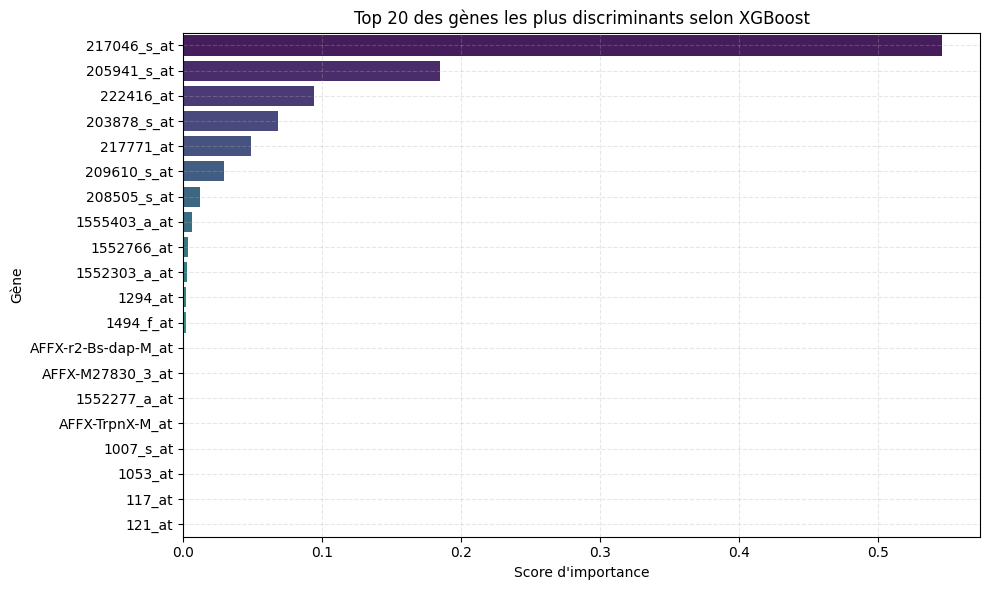

In [55]:
# Extraire les importances
importances = xgb_model.feature_importances_
feature_names = X.columns  # les noms des gènes

# Créer un DataFrame trié
feat_imp = pd.DataFrame({
    'Gène': feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False).head(20)

plt.figure(figsize=(10, 6))
sns.barplot(data=feat_imp, x='Importance', y='Gène', palette='viridis')
plt.title("Top 20 des gènes les plus discriminants selon XGBoost")
plt.xlabel("Score d'importance")
plt.ylabel("Gène")
plt.grid(True, linestyle='--', alpha=0.3)
plt.tight_layout()
plt.show()



Visualisation SVM vs XGBoost sur l’espace PCA

In [56]:
# Ajouter les prédictions dans df_pca (sur l’échantillon de test uniquement)
df_pca.loc[X_test.index, 'Pred_SVM'] = y_pred  # valeurs 0/1
df_pca.loc[X_test.index, 'Pred_XGB'] = y_pred_xgb 
# Ajouter des colonnes avec les labels lisibles pour SVM et XGBoost
df_pca['SVM_Label'] = df_pca['Pred_SVM'].map({1: 'Cancer', 0: 'Sain'}) 
df_pca['XGB_Label'] = df_pca['Pred_XGB'].map({1: 'Cancer', 0: 'Sain'}) 


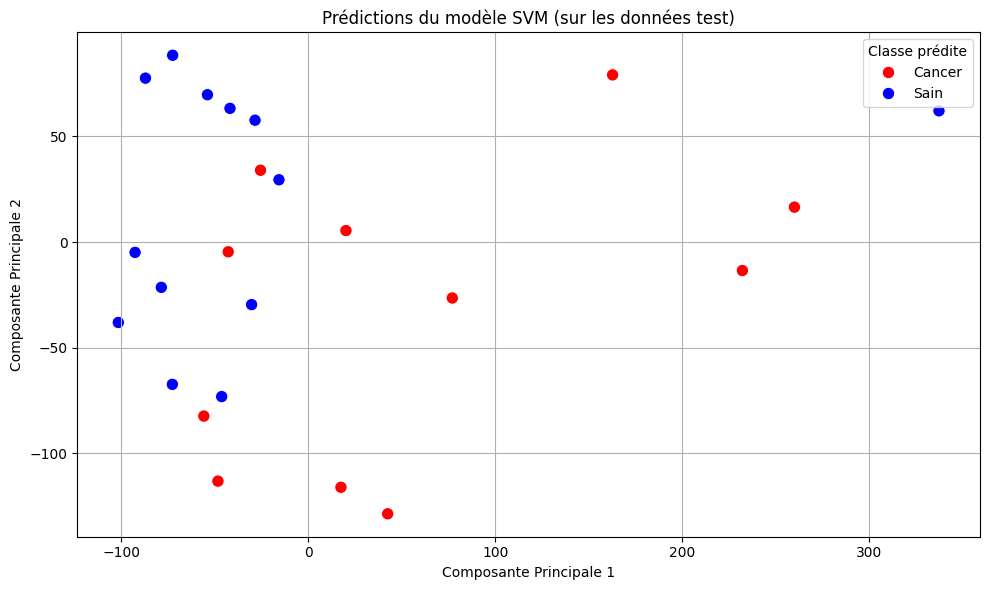

In [57]:
plt.figure(figsize=(10, 6))
sns.scatterplot(
    data=df_pca.loc[X_test.index],
    x='PC1', y='PC2',
    hue='SVM_Label',
    palette={'Sain': 'blue', 'Cancer': 'red'},
    s=80
)
plt.title("Prédictions du modèle SVM (sur les données test)")
plt.xlabel("Composante Principale 1")
plt.ylabel("Composante Principale 2")
plt.legend(title="Classe prédite")
plt.grid(True)
plt.tight_layout()
plt.show()


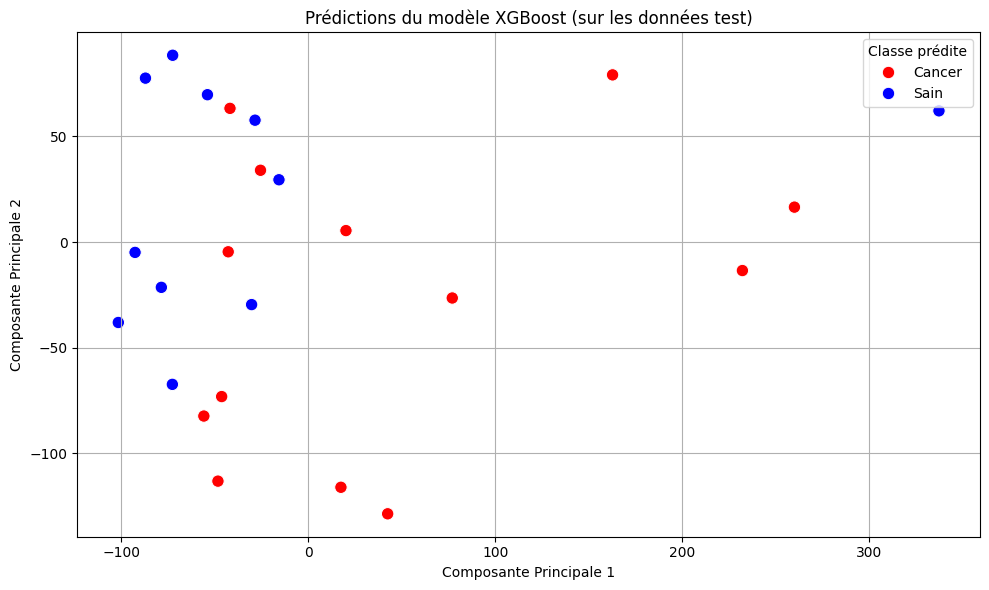

In [58]:
plt.figure(figsize=(10, 6))
sns.scatterplot(
    data=df_pca.loc[X_test.index],
    x='PC1', y='PC2',
    hue='XGB_Label',
    palette={'Sain': 'blue', 'Cancer': 'red'},
    s=80
)
plt.title("Prédictions du modèle XGBoost (sur les données test)")
plt.xlabel("Composante Principale 1")
plt.ylabel("Composante Principale 2")
plt.legend(title="Classe prédite")
plt.grid(True)
plt.tight_layout()
plt.show()


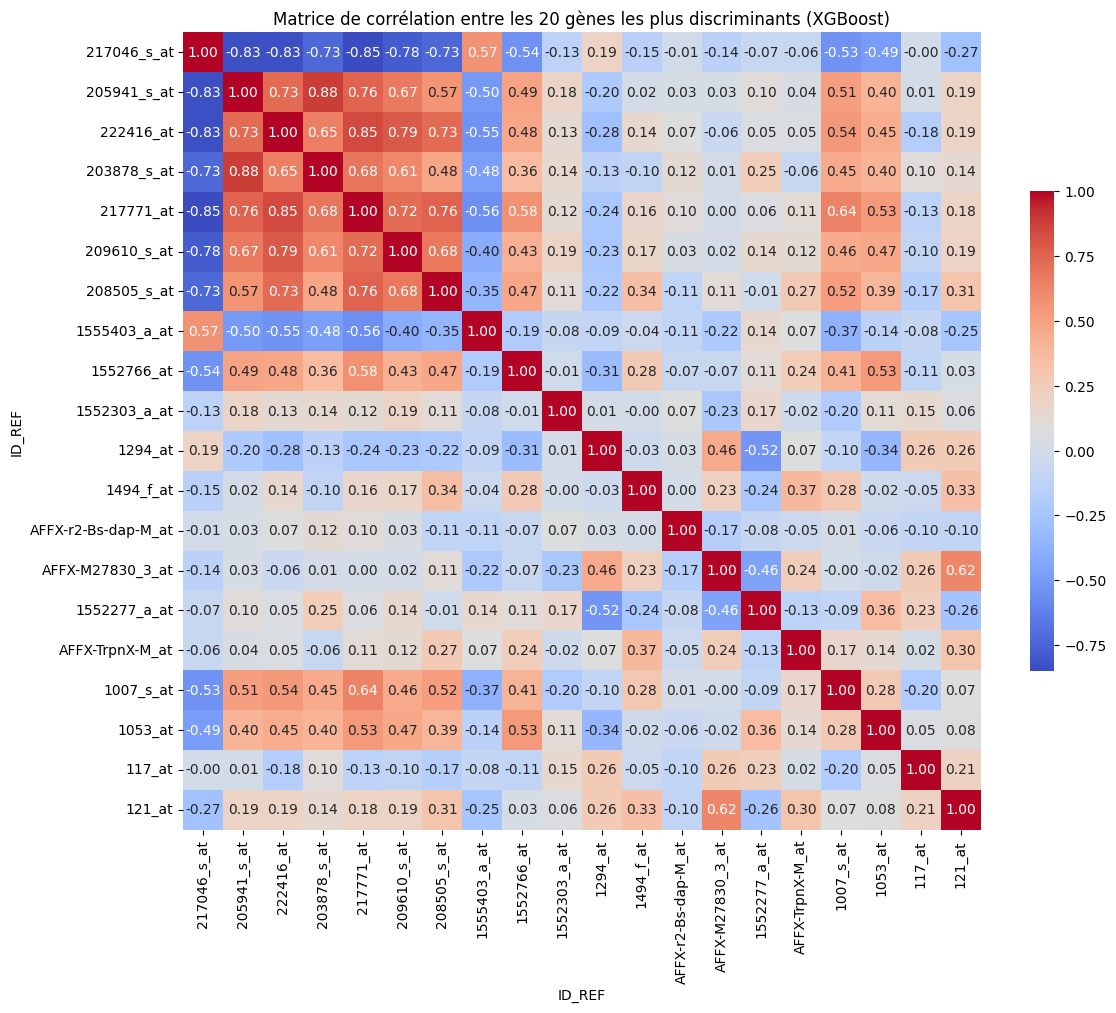

In [59]:
top_genes = feat_imp['Gène'].tolist()[:20]  # top 20 gènes

# Extraire leurs colonnes depuis df_scaled
X_subset = df_scaled[top_genes]

# Calcul de la matrice de corrélation
corr_matrix = X_subset.corr()

# Affichage avec seaborn
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', square=True, cbar_kws={"shrink": .6})
plt.title("Matrice de corrélation entre les 20 gènes les plus discriminants (XGBoost)")
plt.tight_layout()
plt.show()
